In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

Question1 

To generate a random 2 d array from normal distribution numpy has a function numpy.random.randn
uses mean = 0 and standard deviation 1

Reference : https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html

Concept : 
In the context of linear regression, correlations refer to the degree to which independent variables are related to each other. Each column of random matrix is a feature independenlty sampled from normal distribution, by changing S we determine the degree of relation or correlations between these features 
S = I implies no correlations
Source : chat-gpt

coding structure -> self

In [3]:
def generate_input_data(n, S):
    m = 5 ## arbitary chosen no. of columns/features
    ##generate random matrix of size NXM
    random_matrix = np.random.randn(n,m)
    ##GENERATE INPUT DATA MATRIX using np.dot for matrix multiplication
    X = np.dot(random_matrix,S)
    ## X HAS no. of columns equal to desired outputs and each rows corresponds to sample
    return X
   
    

In [4]:
## test function
N = 100 ## SAMPLING SIZE
D = 2 # NO OF FEATURES
M = 5 
S = np.eye(M,D)
#print(generate_input_data(N,S))

Q2 To add zero mean gaussian noise I used numpy.random.normal as it allows specifying sigma and mean unlike randn which uses default values ref: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html 
dimensional mismatch (input N X D and noise is D+1 X 1) tacked by excluding 1st element from noise matrix
Concept : simulate real world scenarios target set itself not ideal maybe measurement noise or other gaussian noice to be added

In [5]:
def generate_target_matrix(X, w, sigma):
    ##check dimenstional mismatch   X = N X D while w = row vector of size D+1
    is_same = X.shape[1] == w.shape[0]
    if(not is_same):
        ## if mismatch reduce exclude 1st element
        w = w[1 :]  # excluded 0TH
        bias = w[0]
    else:
        bias = 0
    ##weighted input
    X_wt = np.dot(X,w)
    ##ADD BIAS
    X_biased = X_wt + bias
    ##add gaussian noise of variance sigma
    noise = np.random.normal(loc=0.0, scale=sigma, size= X_biased.shape)
    ##final target set
    t = X_biased + noise
    return t
    
    
    
    

In [6]:
## test target set generation
X = generate_input_data(N,S)
sigma = 0.1
w = np.random.randn(D+1, 1)
target = generate_target_matrix(X,w,sigma)
print(target.shape)

(100, 1)


Q3 concept: pseudo inverse tackles the problem of computing inverse for least square problems when 
true inverse might not be defined i.e either X has depended variables or isn't sqauare matrix
method used to do so is single value decomposition which is what is used by analytical solver of numpy.linalg
package  ref: https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html 

Ideation : to analyse behavior wrt to scale and to plot log-log plots  vary the input size of N
in powers of 10s   source : self

Method to estimate time : use time library and mark time at the beginning and at end of computation 
and time duration would be given by start-end source : chat gpt

In [7]:
def time_computation(N,D =10):
    duration = []
    for n in N:
        ##use random matrix of size N to check computation
        t = np.random.randn(n)
        ## matrix having same size as that of input matrix
        X = np.random.randn(n,D)
        ##mark start time
        start = time.time()
        ##compute inv using np
        np.linalg.pinv(X) @ t
        ##mark end time
        end = time.time()
        ##compute duration of computation
        d = end - start
        ## to make a plot i need a list of duration against different values of N
        duration.append(d)
    return duration


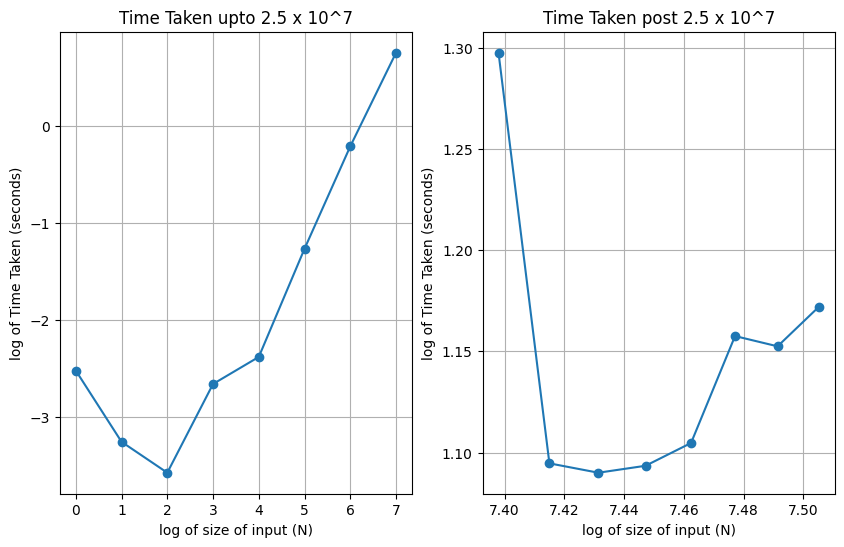

In [8]:
## analyse 
##genearate N for analysis
N = [10**n for n in range(8)]  ##10 data points
##generate computation time
T = time_computation(N)
##plot logN vs logT
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(np.log10(N), np.log10(T) , marker='o')
plt.title('Time Taken upto 2.5 x 10^7')
plt.xlabel('log of size of input (N)')
plt.ylabel('log of Time Taken (seconds)')
plt.grid(True)
##kernel crashed for N = 8 onwards so seperately printing 2.5 x 10^7(hit and trial) onward for analysis
N_high = [(25+n)* 10**6 for n in range(8)]
T_high = time_computation(N_high)
plt.subplot(1,2,2)
plt.plot(np.log10(N_high), np.log10(T_high) , marker='o')
plt.title('Time Taken post 2.5 x 10^7')
plt.xlabel('log of size of input (N)')
plt.ylabel('log of Time Taken (seconds)')
plt.grid(True)
#plt.show()


Observation :  for N upto 10^7  the computational time was within acceptable limits , the time taken was not even substantial until 10^7 even which was not more than 10s
However for even 3.5 time 10^7 compututional time had a sudden spike which caused the kernal to crash, this can be seen in second graph where slope of even log scale is tending to very high values and after last reading i.e 3.2 x 10^6 kernel crashed 

Reasoning : the method used by pinv of numpy package is SVD which involves computing three matrix for every matrix A of which inverse has to be computed and performing matrix multiplication since size of these matrices are NXD , NXN and DXD , no .of computations increases propotionally to N
Beyond a certain threshold, the system may run out of memory, leading to increased computational time or even a crash.
ADDITIONAL INPUT FROM CHAT GPT : total complexity of SVD is O(N.D^2)  this is due to combined effect of matrix mutliplication computation, transpose operations and inverse of singular values



Q4  rmse is root of mean of  square of deviation of predicted and target values
To normalise rmse we divide it by the range of target values so that it gets confined in range 0 to 1
source of normalisation echnique = chat gpt


In [9]:
def nrmse(target,prediction):
    ##calculate rmse
    rmse = np.sqrt(np.mean((target-prediction)**2))
    ##calculate range(
    ran = np.max(target) - np.min(target)
    ##nmrse
    nmrse = rmse/ran
    return nmrse

Q5 : Ref : https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf (pg 4)
notion of stochastic gradient descent/ batch gradient descent and how to formulate
wj = wi(initial gues) + learning_rate(gradient wrt wj) in algorithmic form


In [14]:
def compute_grad(input,weights,target):
    ##compute prediction
    pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
    ##error  N X 1 matrix  error for each sample size
    error = pred - target
    ##mse 2 x error ^2 / no. of samples
    MSE = np.mean(np.square(target - pred))
    ## no. of samples
    N = input.shape[0]    
    ## cal grad wrt weights
    ##basically model 2 x (pred_i - target_i)input_j/Number of samples in matrix format
    grad = 2 * np.dot(input.T,error) / N
    return grad 
    

Q6 : reference : https://math.stackexchange.com/questions/883016/gradient-of-2-norm-squared
To be clear  The following fuction calculates the gradient of square of L2 norm as ultimately L2 regularisation employs  square L2 norm according to https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261. Now tht we have mathematical formulation that grad of L2 norm (simply cummulative sum of squares of weights) is simply 2 times weights , code is trivial

In [11]:
def grad_L2(weights):
    ## weights is D x 1 array
    grad = 2*weights  ### derivation in first link
    return grad
    

Q7: We know that L1 norm is simply sum of absolute value of weights
Clearly this ain't differentiable , so to get around this problem , a thread from stackexchange suggested " This norm is not differentiable with respect to a coordinate where that coordinate is zero. Elsewhere, the partial derivatives are just constants, ±1 depending on the quadrant.

Additional input from gpt : subgradient methods are often used to handle the gradient of the L1 norm. The subgradient of the L1 norm at a point where the vector is not zero is simply the sign of each element of the vector. At points where the vector is zero, any value between -1 and 1 is a valid subgradient.

So I just coded above notions out as follows

In [13]:
def grad_L1(weights):
    ##grad is simply signum of ith element
    grad = np.sign(weights)
    ##assign random value where weights is 0 
    grad[w == 0] = np.random.uniform(-1, 1, np.sum(w == 0)) ##taken directly from chat gpt
    ##breakdown of directly copied line
    #grad[w == 0] selects all elements in grad array where w == 0
    # np.sum(w==0) total elements having value 0 
    #np.random.uniform(-1, 1, np.sum(w == 0)) basically generates array of random values from
    #uniform distribution of size equals to np. of 0 elements
    return grad
    

Q8: Ideation : we have functions for calculating grad of all 3 terms independently
so just have to make a commulative loss function with regularization terms added, for stopping criteria
I could only think of epsilon method , the cost function has converged or assumed minimum value when differnce between consecutive costs less than epsilon

Chat gpt help: make a list appending cost function values computed after every iteration and stopping
criteria will simply be "np.abs(losses[-1] - losses[-2]) < tolerance:"


In [15]:
def Grad_Reg(input, weights, target, alpha1, alpha2, iterations, learningRate):
    costValues = []
    ##lets make cost function  few terms directly copied from prev ans
    for i in range(iterations):  ## try to keep iteratations large so that converge well before
        pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
        ## MSE
        MSE = np.mean(np.square(target - pred))
        ##L1 regularization
        lamda1 = alpha1 
        L1 = lamba1 * np.sum(np.abs(weights)) ## simply coded defination
        ###L2 regularization
        lamda2= alpha2 
        L2 = lamba2 * np.sum(np.square(weights))
        ##NET COST
        cost = MSE + L1 + L2
        #3store cost
        costValues.append(cost)
        ## net grad  directly use prev functions
        gradient = compute_grad(input, weights, target) + grad_L1(weights) + grad_L2(weights)
        ##update weight acc to basic gradient descent
        r= learningRate ## to be tuned
        weights = weights - r * gradient
        
        ##stopping criteria  credits gpt
        epsilon = 0.01  #3 to be tuned
        if i > 0 and np.abs(cost[-1] - cost[-2]) < epsilon:
            print(f"Converged after {i} iterations.")
            break
    return weights
        
    
    

In [ ]:
## test gradient descent related functions


Q9: 